In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   #for data visualization and graphical plotting
from matplotlib import style      #for styling the plot
style.use("ggplot")

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filterout useless data


from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import re
import string

In [3]:
data = pd.read_csv("/content/drive/MyDrive/labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [6]:
data["labels"] = data["class"].map({0: "Hate Speech",
                                    1: "Offensive Language",
                                    2: "No Hate and Offensive"})
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet                 labels  
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     Offensive Language  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     Offensive Language  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...     Offensive Language  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     Offensive Language  


In [7]:
print(data["tweet"].iloc[0],"\n")
print(data["tweet"].iloc[1],"\n")
print(data["tweet"].iloc[2],"\n")
print(data["tweet"].iloc[3],"\n")
print(data["tweet"].iloc[4],"\n")

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!! 

!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit 

!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny 

!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361; 



In [8]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stopword = stopwords.words('english')

In [11]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [12]:
nltk.download('punkt')
data.tweet=data['tweet'].apply(clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
tweetData = data.drop_duplicates("tweet")

In [14]:
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   labels  24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


In [15]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [16]:
nltk.download('wordnet')
tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-16-6b8ff0ca977c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))


In [17]:
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [18]:
tweetData['labels'].value_counts()

Offensive Language       18984
No Hate and Offensive     4113
Hate Speech               1409
Name: labels, dtype: int64

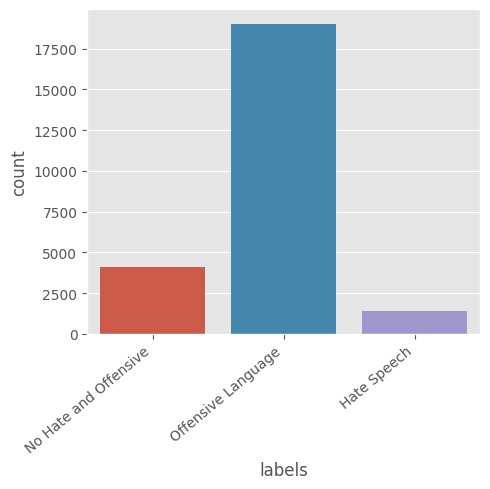

In [19]:
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=tweetData)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

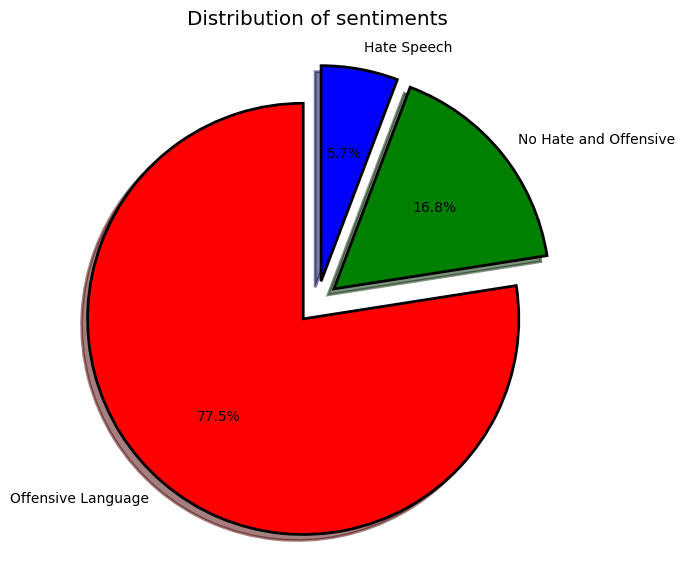

In [20]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = tweetData['labels'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

In [21]:
non_hate_tweets = tweetData[tweetData.labels=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,labels
0,rt mayasolovely woman shouldnt complain cleani...,No Hate and Offensive
40,momma said pussy cats inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,allaboutmanfeet woof woof hot soles,No Hate and Offensive
67,allyhaaaaa lemmie eat oreo amp dishes one oreo...,No Hate and Offensive


In [22]:
non_hate_tweets.value_counts()

tweet                                                                                                           labels               
                                                                                                                No Hate and Offensive    1
rt joleendoreen kik group called party line old charlie barber always hogging calls                             No Hate and Offensive    1
rt kickin trash cans golf cart yeeyee jbilinovich                                                               No Hate and Offensive    1
rt kickman giants pitiful jetspitiful mets pitiful yankeespitiful nets pitiful knickspitiful ny sports pitiful  No Hate and Offensive    1
rt kid listened nas showed new perspective coming ghetto like pimp c                                            No Hate and Offensive    1
                                                                                                                                        ..
jstarrtweets took harder rivera 

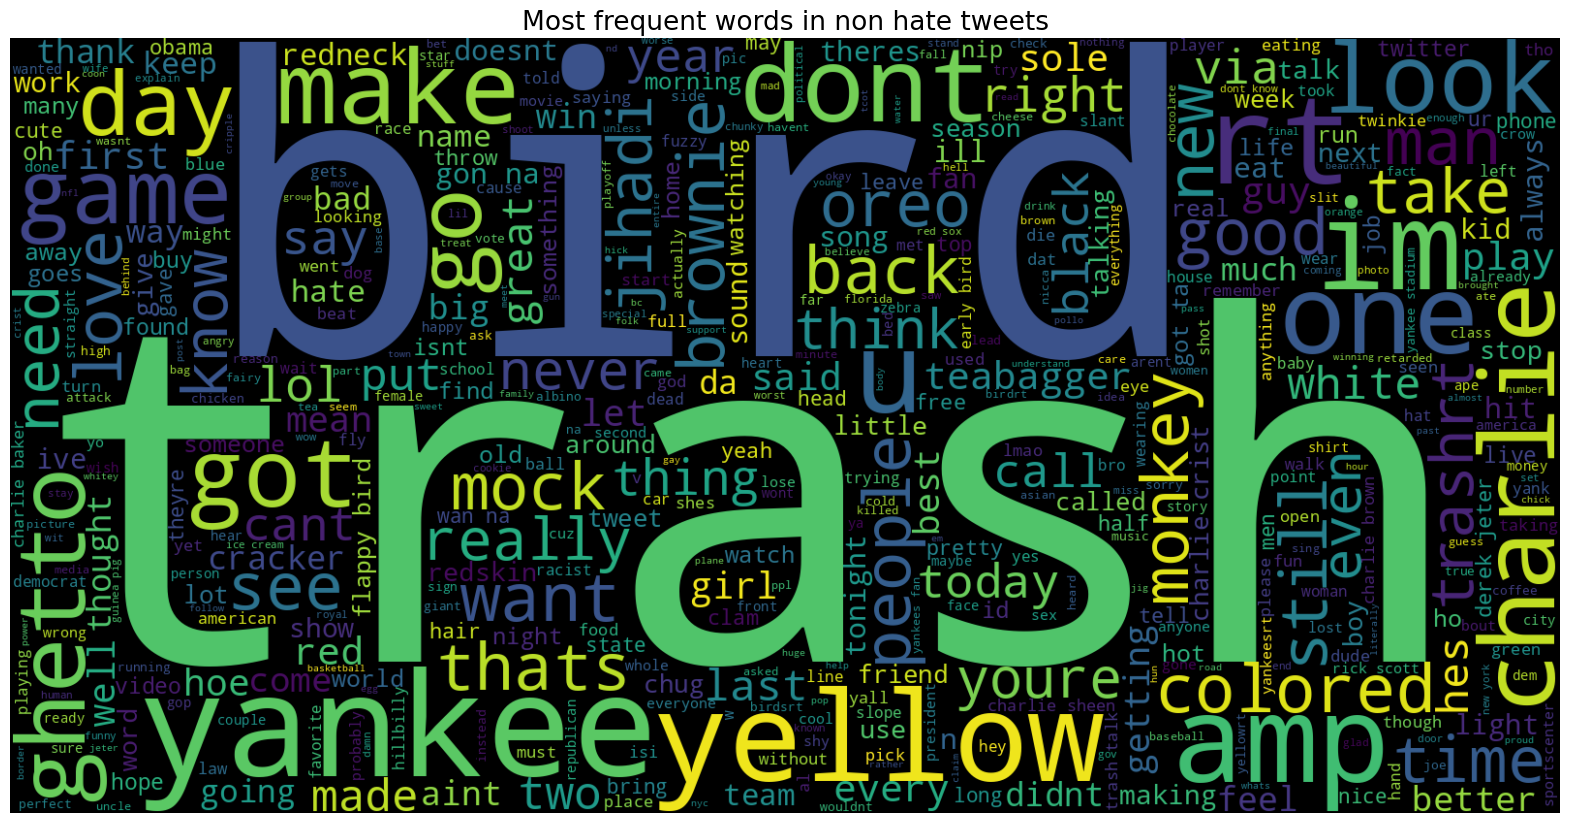

In [23]:
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

In [24]:
vect=TfidfVectorizer(ngram_range=(1,2)).fit(tweetData['tweet'])

In [25]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 161774
First 200 features: 
 ['aa' 'aa classes' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begins' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aaliyah curving'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhlovee' 'aaliyahhlovee yu'
 'aamaadmiparty' 'aamaadmiparty mix' 'aampt' 'aampt ackin' 'aamu']


In [26]:
vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])

In [27]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 310426
First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt']


In [28]:
X = tweetData['tweet']
Y = tweetData['labels']
X = vect.transform(X)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (19604, 310426)
Size of Y_train (19604,)
Size of X_test (4902, 310426)
Size of Y_test (4902,)


In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

In [32]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 85.31%


In [33]:
print(confusion_matrix(Y_test, logreg_predict))
print("\n")
print(classification_report(Y_test, logreg_predict))

[[  12   10  261]
 [   0  403  405]
 [   3   41 3767]]


                       precision    recall  f1-score   support

          Hate Speech       0.80      0.04      0.08       283
No Hate and Offensive       0.89      0.50      0.64       808
   Offensive Language       0.85      0.99      0.91      3811

             accuracy                           0.85      4902
            macro avg       0.85      0.51      0.54      4902
         weighted avg       0.85      0.85      0.82      4902



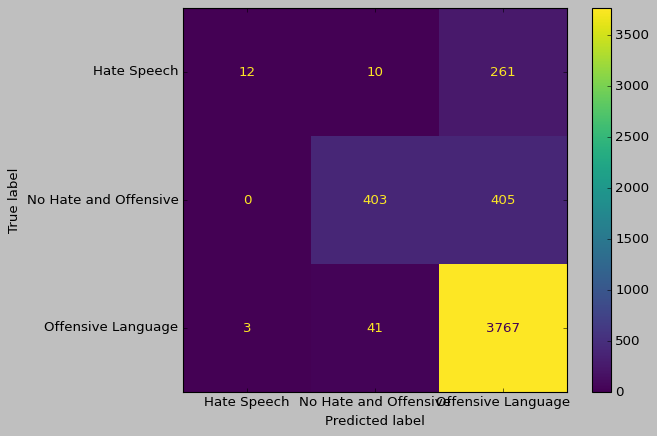

In [34]:
style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [35]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [36]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, Y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.88
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [37]:
log_grid_pred = grid.predict(X_test)

In [38]:
log_grid_acc = accuracy_score(log_grid_pred, Y_test)
print("Test accuracy: {:.2f}%".format(log_grid_acc*100))

Test accuracy: 89.17%


In [39]:
print(confusion_matrix(Y_test, log_grid_pred))
print("\n")
print(classification_report(Y_test, log_grid_pred))

[[  29   17  237]
 [   2  626  180]
 [  19   76 3716]]


                       precision    recall  f1-score   support

          Hate Speech       0.58      0.10      0.17       283
No Hate and Offensive       0.87      0.77      0.82       808
   Offensive Language       0.90      0.98      0.94      3811

             accuracy                           0.89      4902
            macro avg       0.78      0.62      0.64      4902
         weighted avg       0.88      0.89      0.87      4902



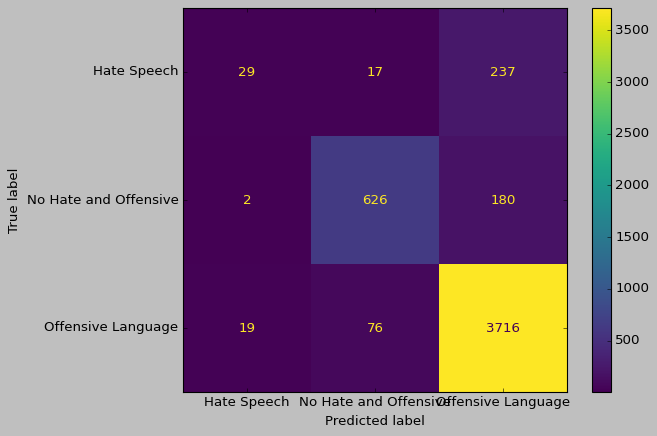

In [40]:
style.use('classic')
cm = confusion_matrix(Y_test, log_grid_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()

In [41]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train) #loading x_train and y_train data on model
dtree_predict = dtree.predict(X_test) #predicting the value for test data
dtree_acc = accuracy_score(dtree_predict, Y_test)

In [42]:
print("Test accuracy: {:.2f}%".format(dtree_acc*100))

Test accuracy: 87.58%


In [43]:
print(confusion_matrix(Y_test, dtree_predict))
print("\n")
print(classification_report(Y_test, dtree_predict))

[[  56   39  188]
 [  21  682  105]
 [  89  167 3555]]


                       precision    recall  f1-score   support

          Hate Speech       0.34      0.20      0.25       283
No Hate and Offensive       0.77      0.84      0.80       808
   Offensive Language       0.92      0.93      0.93      3811

             accuracy                           0.88      4902
            macro avg       0.68      0.66      0.66      4902
         weighted avg       0.86      0.88      0.87      4902



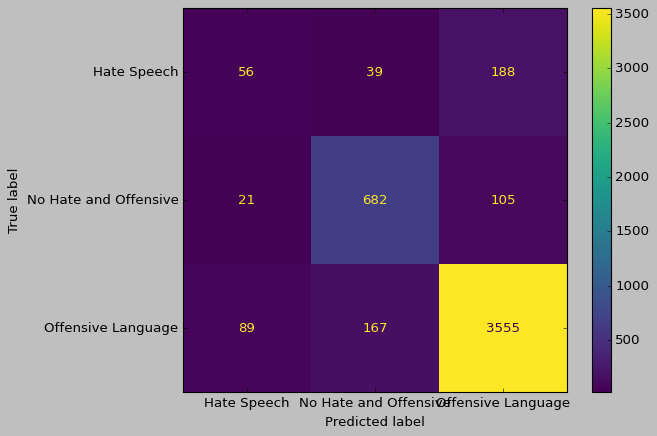

In [44]:
style.use('classic')
cm = confusion_matrix(Y_test, dtree_predict, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot()

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, dtree_predict)

0.8757649938800489

In [67]:
sample1 = " Welcome to wise project "
sample1= clean(sample1)

In [68]:
sample1

'welcome wise project'

In [69]:
data1 = vect.transform([sample1]).toarray()

In [70]:
data1

array([[0., 0., 0., ..., 0., 0., 0.]])

In [71]:
dtree.predict(data1)

array(['No Hate and Offensive'], dtype=object)

In [58]:
sample = " bad bitches is the only thing that i like "
sample = clean(sample)

In [59]:
sample

'bad bitches thing like'

In [60]:
data2 = vect.transform([sample]).toarray()

In [61]:
data2

array([[0., 0., 0., ..., 0., 0., 0.]])

In [62]:
dtree.predict(data2)

array(['Offensive Language'], dtype=object)

In [83]:
sample2 = "hes a beaner smh you can tell hes a mexican"
sample2 = clean(sample2)

In [84]:
sample2

'hes beaner smh tell hes mexican'

In [85]:
data3 = vect.transform([sample2]).toarray()

In [86]:
data3

array([[0., 0., 0., ..., 0., 0., 0.]])

In [87]:
dtree.predict(data3)

array(['Hate Speech'], dtype=object)

In [88]:
sample3 = " The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"
sample3 = clean(sample3)

In [89]:
sample3

'shit blows meclaim faithful somebody still fucking hoes'

In [90]:
data4 = vect.transform([sample3]).toarray()

In [91]:
data4

array([[0., 0., 0., ..., 0., 0., 0.]])

In [92]:
dtree.predict(data4)

array(['Offensive Language'], dtype=object)